# FFT for image reconstruction

We present a quick intro showing how FFT can be applied for image compression.

The core thing to know about FFT is that we go **from the pixel space to the frequency space**. While the shape remains the same, every value in the frequency domain contributes to ALL pixels in the pixel space. This is the core thing to understand regarding the FFTs. We can visualize it below. 

The original image is translated into the frequency domain, as you can see the highest magnitude of pixels in the low frequency. This is the cause for natural images; the majority of the images are a slow change in pixel values. If we remove these low frequencies, we end up with only the pixels representing a fast change in various directions, aka the edges.

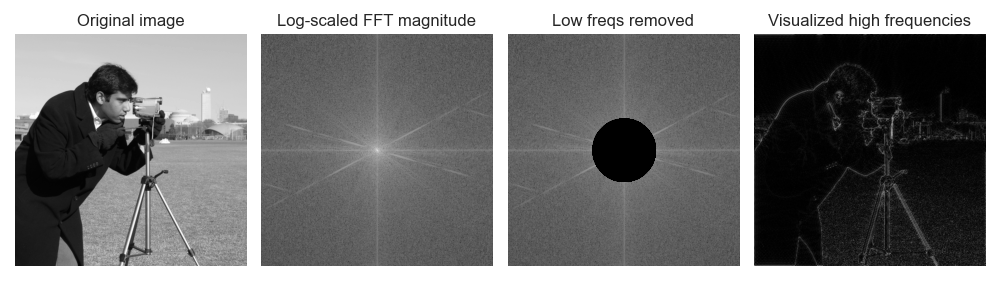

If we do the oppisute, we only keep the low frequencies, we remove all the sharp edges and an image gets super blurry. 

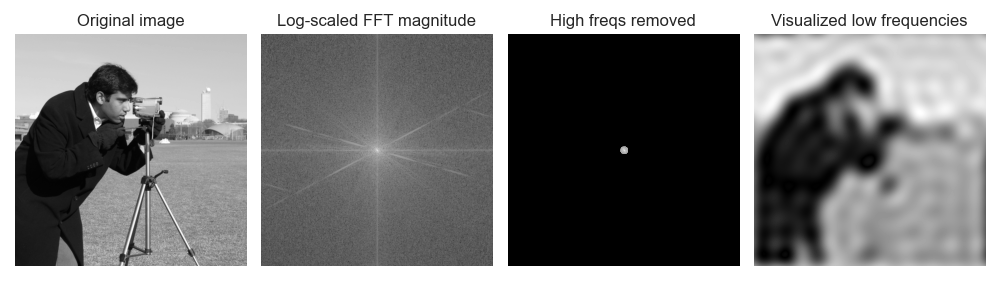

https://towardsdatascience.com/the-fourier-transform-4-putting-the-fft-to-work-38dd84dc814/

## Simple math intro

When applying the 2D Fast Fourier Transform to an image (e.g., a $512 \times 512$ pixel image), the output is a $512 \times 512$ array of complex numbers. Each complex number has two components:

## Real Part ($\mathfrak{Re}$)

The real part of the FFT output represents the cosine components of the image's frequency content.

$\mathfrak{Re}[F(u,v)] = \sum_{x=0}^{M-1} \sum_{y=0}^{N-1} f(x,y) \cos\left(2\pi\left(\frac{ux}{M} + \frac{vy}{N}\right)\right)$

Where:
- $f(x,y)$ is the image pixel value at coordinates $(x,y)$
- $M, N$ are the image dimensions
- $u, v$ are the frequency coordinates

**Properties of the Real Part:**
- Represents amplitude contribution of cosine waves
- Symmetric around the center: $\mathfrak{Re}[F(u,v)] = \mathfrak{Re}[F(-u,-v)]$
- Central values (low frequencies) typically have larger magnitude

## Imaginary Part ($\mathfrak{Im}$)

The imaginary part represents the sine components of the image's frequency content.

$\mathfrak{Im}[F(u,v)] = -\sum_{x=0}^{M-1} \sum_{y=0}^{N-1} f(x,y) \sin\left(2\pi\left(\frac{ux}{M} + \frac{vy}{N}\right)\right)$

**Properties of the Imaginary Part:**
- Determines the phase information of frequency components
- Anti-symmetric around the center: $\mathfrak{Im}[F(u,v)] = -\mathfrak{Im}[F(-u,-v)]$
- Captures the spatial shifts of frequency patterns

## Relationship to Image Properties

Together, these components fully characterize the frequency content of the image:

**Magnitude Spectrum:**
$|F(u,v)| = \sqrt{\mathfrak{Re}[F(u,v)]^2 + \mathfrak{Im}[F(u,v)]^2}$

**Phase Spectrum:**
$\phi(u,v) = \tan^{-1}\left(\frac{\mathfrak{Im}[F(u,v)]}{\mathfrak{Re}[F(u,v)]}\right)$

The magnitude represents the strength of each frequency component, while the phase indicates its relative position or shift within the image.

### Imports

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.colors import LogNorm

## 1D example

Let's say we have a simple 1D image, with 4 values `[0, 0, 255, 255]` we want to apply an FFT onto it to transfrom it into the frequency domain

In [4]:
pixel_array = np.array([0, 0, 255, 255])

# Compute FFT (forward transform to frequency domain)
freq_components = np.fft.fft(pixel_array)
print("freq_components: ", freq_components)

# Compute IFFT (inverse transform back to spatial domain)
reconstructed_pixels = np.fft.ifft(freq_components)

# Since IFFT can produce complex values due to numerical precision,
# we take the real part and convert to the original data type
reconstructed_pixels = np.real(reconstructed_pixels).astype(np.uint8)
print("reconstructed_pixels: ", reconstructed_pixels)

freq_components:  [ 510.  +0.j -255.+255.j    0.  +0.j -255.-255.j]
reconstructed_pixels:  [  0   0 255 255]


Let's analyze how the numbers here are calculated on the 1st 255 examples (3rd pixel). In the Inverse Discrete Fourier Transform (IDFT), each pixel value is reconstructed by summing the contributions from all frequency components. For a 1D array of length N, the formula is:

$$f(x) = \frac{1}{N} \sum_{u=0}^{N-1} F(u) \cdot e^{j2\pi ux/N}$$

Given your frequency components:
- $F(0) = 510 + 0j$ (DC component)
- $F(1) = -255 + 255j$ (First frequency)
- $F(2) = 0 + 0j$ (Second frequency)
- $F(3) = -255 - 255j$ (Third frequency)

We'll calculate $f(2)$ (the third pixel, which should be 255):

$$f(2) = \frac{1}{4} \sum_{u=0}^{3} F(u) \cdot e^{j2\pi u \cdot 2/4}$$

Breaking this down for each frequency component:

1. $u=0$: $\frac{1}{4} \cdot (510 + 0j) \cdot e^{j2\pi \cdot 0 \cdot 2/4} = \frac{510}{4} \cdot 1 = 127.5$

2. $u=1$: $\frac{1}{4} \cdot (-255 + 255j) \cdot e^{j2\pi \cdot 1 \cdot 2/4} = \frac{1}{4} \cdot (-255 + 255j) \cdot e^{j\pi} = \frac{1}{4} \cdot (-255 + 255j) \cdot (-1) = \frac{255 - 255j}{4}$

3. $u=2$: $\frac{1}{4} \cdot (0 + 0j) \cdot e^{j2\pi \cdot 2 \cdot 2/4} = 0$

4. $u=3$: $\frac{1}{4} \cdot (-255 - 255j) \cdot e^{j2\pi \cdot 3 \cdot 2/4} = \frac{1}{4} \cdot (-255 - 255j) \cdot e^{j3\pi} = \frac{1}{4} \cdot (-255 - 255j) \cdot (-j) = \frac{255j + 255}{4}$

Now, summing all components:
$$f(2) = 127.5 + \frac{255 - 255j}{4} + 0 + \frac{255j + 255}{4}$$

Simplifying:
$$f(2) = 127.5 + \frac{255 + 255}{4} = 127.5 + 127.5 = 255$$

The imaginary parts cancel out, leaving us with the real value 255, which matches the original pixel value!

This demonstrates how each frequency component contributes to reconstruct the original pixel value, with the phases determining how these components combine.

## Compression 

Now let's say we want to do a minimal example of "compression" via FFT. We will:
- execute an FFT on the image
- keep only two components with the most significant magnitude
- use these two for reconstuction

In [5]:
pixel_array = np.array([0, 0, 255, 255])

# Compute FFT (forward transform to frequency domain)
freq_components = np.fft.fft(pixel_array)
print("Original freq_components: ", freq_components)

# Find the magnitudes of each frequency component
magnitudes = np.abs(freq_components)
print("Magnitudes: ", magnitudes)

# Create a copy of frequency components to modify
filtered_components = np.copy(freq_components)

# Keep only the two components with highest magnitude
# First, get indices sorted by magnitude
sorted_indices = np.argsort(magnitudes)[::-1]  # Descending order
print("Indices sorted by magnitude: ", sorted_indices)

# Keep only the top 2 components, set others to zero
keep_indices = sorted_indices[:2]  # Top 2 indices
for i in range(len(filtered_components)):
    if i not in keep_indices:
        filtered_components[i] = 0

print("Filtered freq_components: ", filtered_components)

# Compute IFFT (inverse transform back to spatial domain)
reconstructed_pixels = np.fft.ifft(filtered_components)

# Since IFFT can produce complex values due to numerical precision,
# we take the real part and convert to the original data type
reconstructed_pixels = np.real(reconstructed_pixels).astype(np.uint8)
print("Reconstructed pixels: ", reconstructed_pixels)

Original freq_components:  [ 510.  +0.j -255.+255.j    0.  +0.j -255.-255.j]
Magnitudes:  [510.         360.62445841   0.         360.62445841]
Indices sorted by magnitude:  [0 3 1 2]
Filtered freq_components:  [ 510.  +0.j    0.  +0.j    0.  +0.j -255.-255.j]
Reconstructed pixels:  [ 63  63 191 191]


And now math step by step:

```
Filtered freq_components: [ 510. +0.j 0. +0.j 0. +0.j -255.-255.j]
```

Let's calculate the value at pixel index 2 using the inverse FFT formula:

$$f(2) = \frac{1}{4} \sum_{u=0}^{3} F(u) \cdot e^{j2\pi u \cdot 2/4}$$

With only two non-zero components:

1. $u=0$: $\frac{1}{4} \cdot (510 + 0j) \cdot e^{j2\pi \cdot 0 \cdot 2/4} = \frac{510}{4} \cdot 1 = 127.5$

2. $u=3$: $\frac{1}{4} \cdot (-255 - 255j) \cdot e^{j2\pi \cdot 3 \cdot 2/4} = \frac{1}{4} \cdot (-255 - 255j) \cdot e^{j3\pi} = \frac{1}{4} \cdot (-255 - 255j) \cdot (-j) = \frac{255j + 255}{4} = \frac{255}{4} + \frac{255j}{4}$

Summing these two components:
$$f(2) = 127.5 + \frac{255}{4} + \frac{255j}{4}$$

The real part (which is what we keep after using `np.real()`) is:
$$\text{Real}(f(2)) = 127.5 + \frac{255}{4} = 127.5 + 63.75 = 191.25$$

When converted to uint8, this becomes 191, matching our reconstructed value!

The key insight here is that by removing some frequency components, we've lost some of the signal structure. The original pixel value was 255, but with only two frequency components, we can only reconstruct an approximation of 191. This illustrates the fundamental principle behind lossy compression: by keeping only the most significant frequency components, we can approximate the original signal while using less data.

## Single color example

The first value in the frequency space is called DC, and it represents the most dominant color or the average color of an image. Since it is the case that images are a uniform color, we just need a single value to perfectly recreate an image.

In [6]:
pixel_array = np.array([120, 120, 120, 120])

# Compute FFT (forward transform to frequency domain)
freq_components = np.fft.fft(pixel_array)
print("Original freq_components: ", freq_components)

# Find the magnitudes of each frequency component
magnitudes = np.abs(freq_components)
print("Magnitudes: ", magnitudes)

# Create a copy of frequency components to modify
filtered_components = np.copy(freq_components)

# Keep only the two components with highest magnitude
# First, get indices sorted by magnitude
sorted_indices = np.argsort(magnitudes)[::-1]  # Descending order
print("Indices sorted by magnitude: ", sorted_indices)

# Keep only the top 2 components, set others to zero
keep_indices = sorted_indices[:1]  # Top 1 indices
for i in range(len(filtered_components)):
    if i not in keep_indices:
        filtered_components[i] = 0

print("Filtered freq_components: ", filtered_components)

# Compute IFFT (inverse transform back to spatial domain)
reconstructed_pixels = np.fft.ifft(filtered_components)

# Since IFFT can produce complex values due to numerical precision,
# we take the real part and convert to the original data type
reconstructed_pixels = np.real(reconstructed_pixels).astype(np.uint8)
print("Reconstructed pixels: ", reconstructed_pixels)

Original freq_components:  [480.+0.j   0.+0.j   0.+0.j   0.+0.j]
Magnitudes:  [480.   0.   0.   0.]
Indices sorted by magnitude:  [0 3 2 1]
Filtered freq_components:  [480.+0.j   0.+0.j   0.+0.j   0.+0.j]
Reconstructed pixels:  [120 120 120 120]


## Image compression with FFT

We showed above how the FFT can be applied for image compression on our simple 1D example. Now we want to do the same for images. Let's start with opening an image.

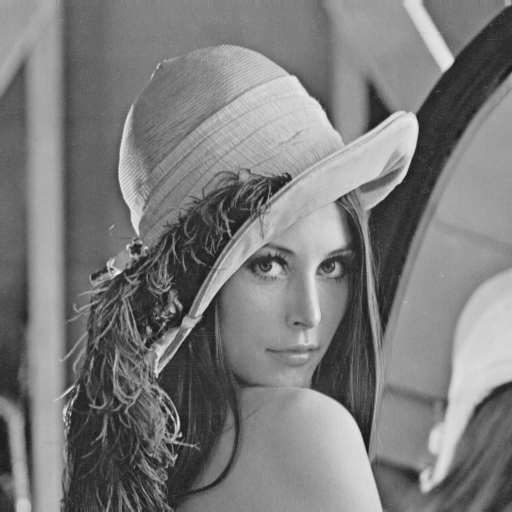

In [5]:
image_path = "lenna.png"
img = Image.open(image_path).convert('L')
img

In [6]:
img_array = np.array(img)
height, width = img_array.shape
height, width

(512, 512)

## FFT

When we apply FFT to an image, we get an array of the same shape as the original image, but now in the frequency domain. As we explained before, each input in the frequency domain is a real and imaginary number that we use to represent the signal frequency.

In [ ]:
f_transform = np.fft.fft2(img_array)
print(f_transform.shape)
print(f_transform[0, 1], " ...")

(512, 512)
(-455357.0652701347+2392745.8118087193j)  ...


In [ ]:
def fft_compression_demo(image_path, percentages=[1, 5, 10, 20, 50]):
    # Load image and convert to grayscale
    img = Image.open(image_path).convert('L')
    img_array = np.array(img)
    
    # Get image dimensions
    height, width = img_array.shape
    
    # Compute 2D FFT
    f_transform = np.fft.fft2(img_array)
    
    # Shift the zero frequency component to the center
    f_transform_shifted = np.fft.fftshift(f_transform)
    
    # Create a larger figure with more rows for better visualization
    rows = len(percentages) + 1  # One row for original + one row per percentage
    cols = 3  # Original/reconstructed image, kept frequencies mask, difference image
    fig = plt.figure(figsize=(15, 4*rows))
    
    # Plot original image in first row
    ax1 = plt.subplot(rows, cols, 1)
    plt.imshow(img_array, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # Plot FFT magnitude in first row
    ax2 = plt.subplot(rows, cols, 2)
    plt.imshow(np.log1p(np.abs(f_transform_shifted)), cmap='viridis')
    plt.title('FFT Magnitude (log scale)')
    plt.colorbar(shrink=0.7)
    plt.axis('off')
    
    # Plot FFT phase in first row
    ax3 = plt.subplot(rows, cols, 3)
    plt.imshow(np.angle(f_transform_shifted), cmap='hsv')
    plt.title('FFT Phase')
    plt.colorbar(shrink=0.7)
    plt.axis('off')
    
    # Total number of coefficients
    total_coeffs = height * width
    
    # Process each compression percentage
    for i, percent in enumerate(percentages):
        # Calculate row index - we need to add 1 since matplotlib subplot indices start at 1
        row_idx = i + 1  # First row is for originals (index 0 + 1 = 1)
        
        # Calculate number of coefficients to keep
        keep_fraction = percent / 100.0
        num_coeffs_to_keep = int(total_coeffs * keep_fraction)
        
        # Create a copy of the FFT for this compression level
        f_transform_compressed = f_transform_shifted.copy()
        
        # Get magnitude of FFT coefficients
        magnitude_spectrum = np.abs(f_transform_compressed)
        
        # Create a mask to keep only the top coefficients
        mask = np.ones_like(f_transform_compressed, dtype=bool)
        threshold = np.sort(magnitude_spectrum.flatten())[-num_coeffs_to_keep]
        mask[magnitude_spectrum < threshold] = False
        
        # Apply mask to keep only the most significant coefficients
        f_transform_compressed[~mask] = 0
        
        # Count non-zero coefficients (should match our target)
        nonzero_count = np.count_nonzero(f_transform_compressed)
        
        # Perform inverse FFT shift and then inverse FFT
        f_inverse_shifted = np.fft.ifftshift(f_transform_compressed)
        img_reconstructed = np.fft.ifft2(f_inverse_shifted).real
        
        # Ensure pixel values are in valid range
        img_reconstructed = np.clip(img_reconstructed, 0, 255).astype(np.uint8)
        
        # Plot reconstructed image (row_idx+1 because we've already used row 1)
        plt.subplot(rows, cols, (row_idx+1) * cols - 2)  # First column of current row
        plt.imshow(img_reconstructed, cmap='gray')
        plt.title(f'Reconstructed with {percent}% coefficients\n({nonzero_count}/{total_coeffs})')
        plt.axis('off')
        
        # Plot the mask showing which frequencies were kept
        plt.subplot(rows, cols, (row_idx+1) * cols - 1)  # Second column of current row
        mask_display = mask  # Show kept frequencies
        plt.imshow(mask_display, cmap='hot')
        plt.title(f'Kept frequencies ({percent}%)')
        plt.axis('off')
        
        # Plot difference image
        plt.subplot(rows, cols, (row_idx+1) * cols)  # Third column of current row
        diff_img = np.abs(img_array.astype(np.float32) - img_reconstructed.astype(np.float32))
        plt.imshow(diff_img, cmap='viridis')
        plt.title(f'Difference (original - {percent}%)')
        plt.colorbar(shrink=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Return the FFT data for further exploration
    return f_transform_shifted, img_array

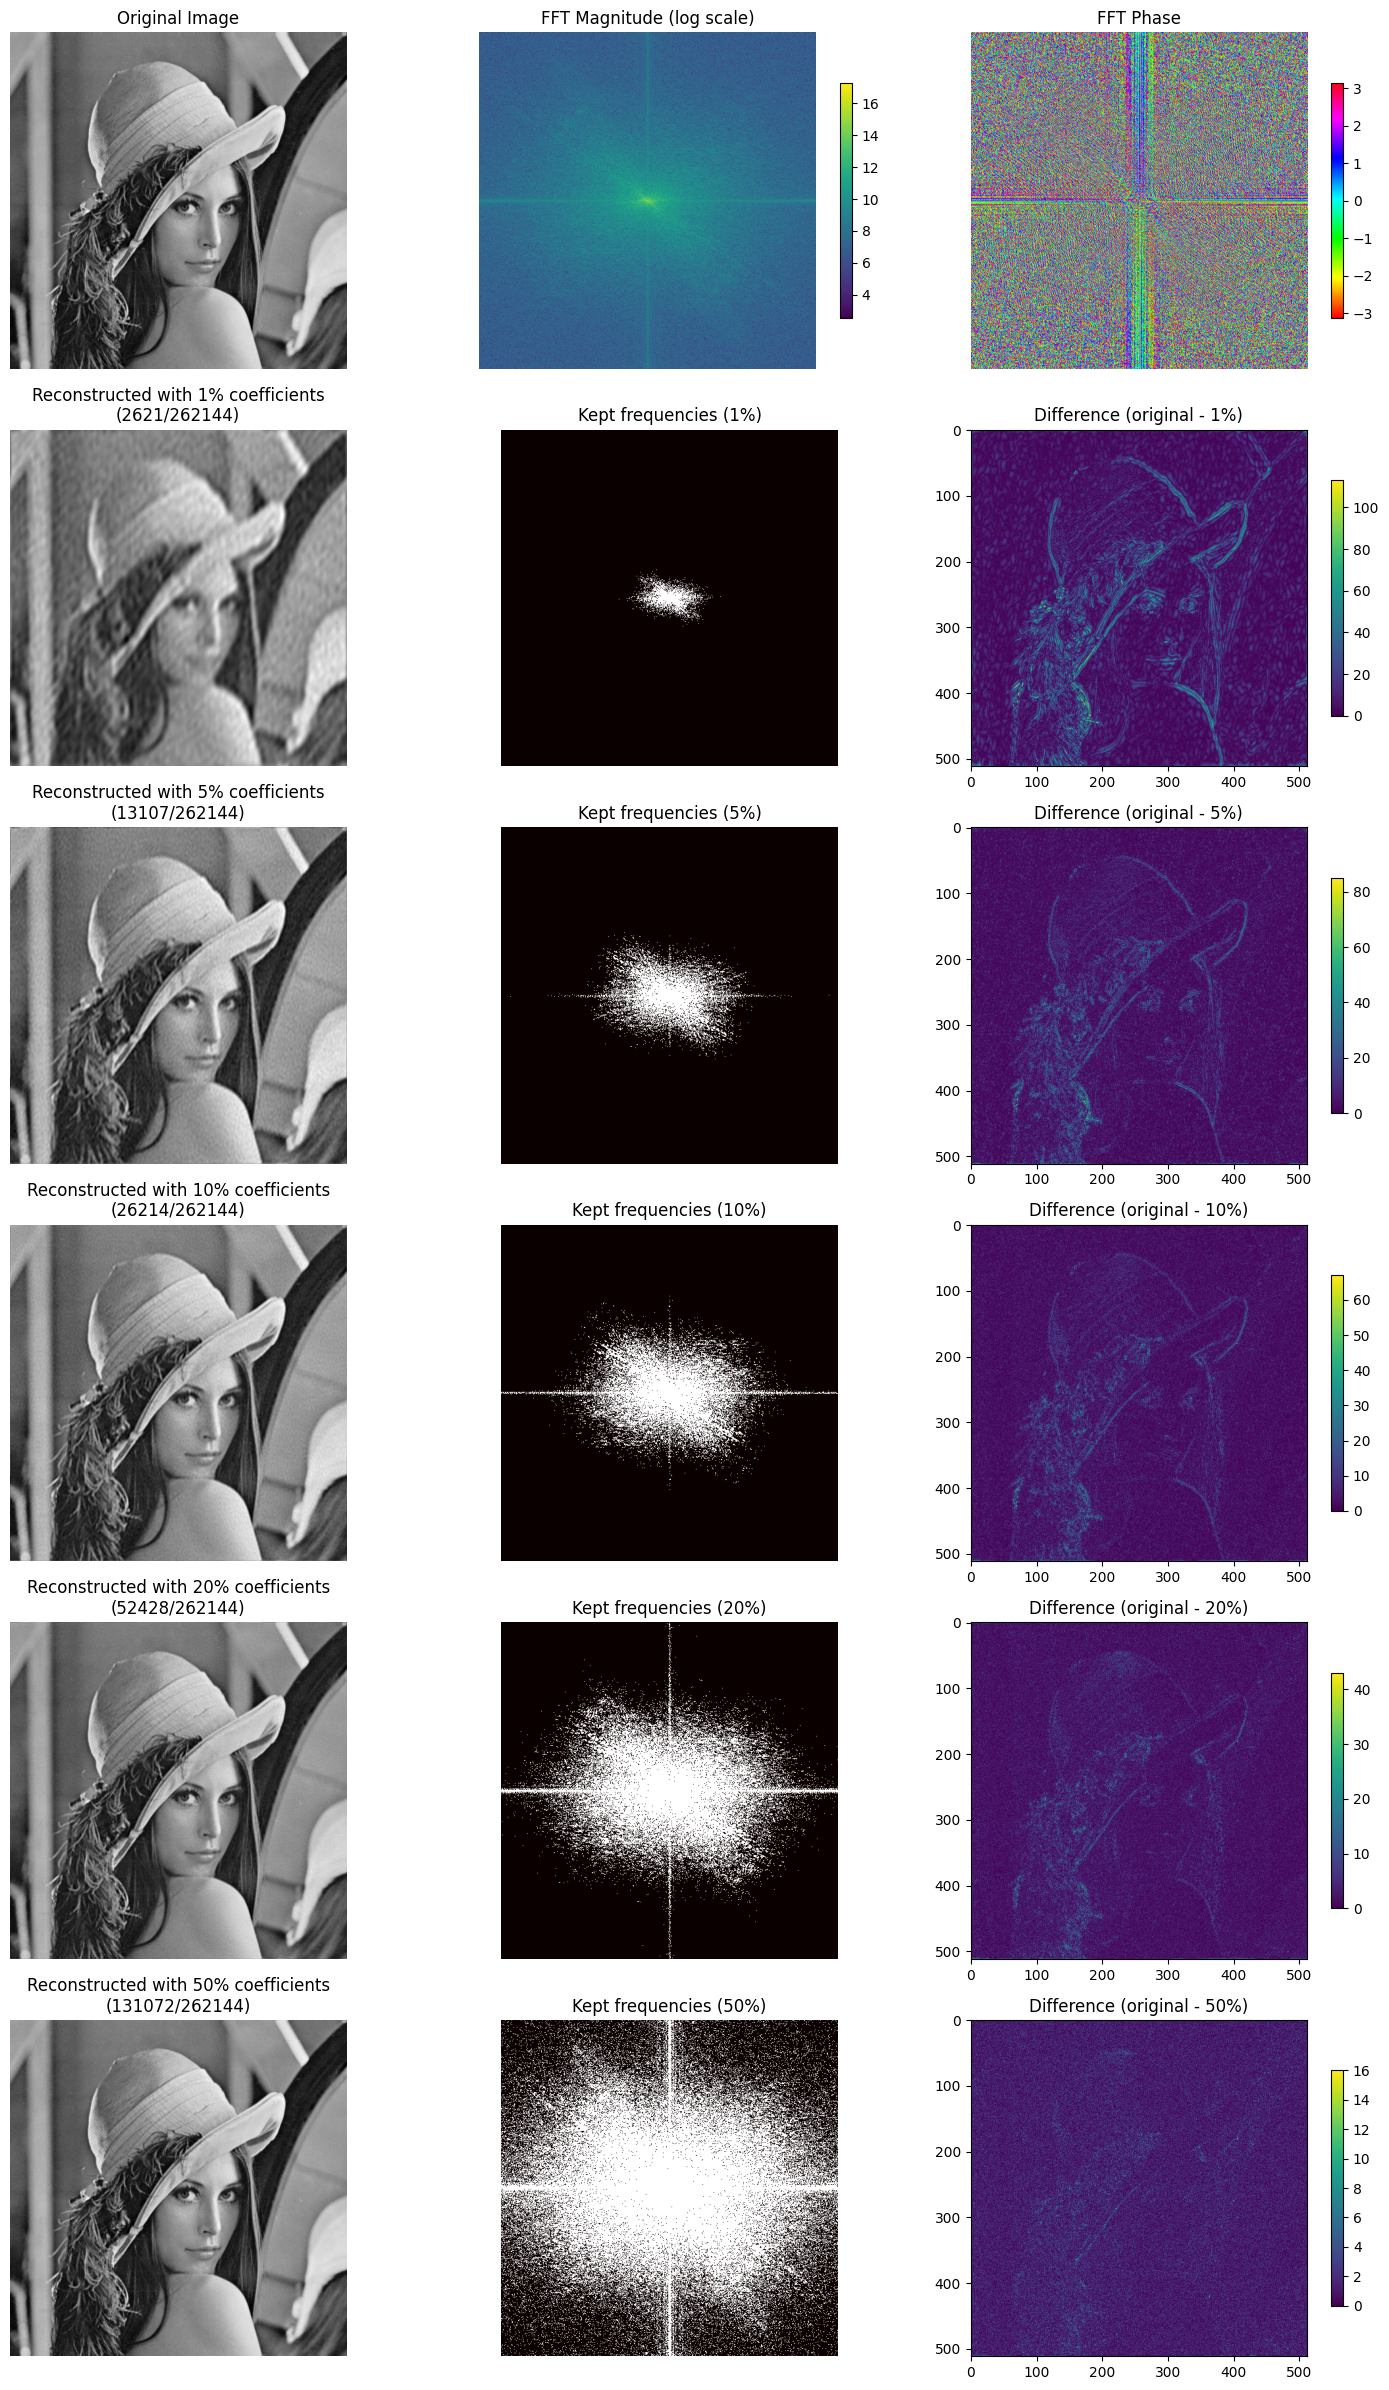

In [10]:
# Example usage
image_path = "lenna.png"  # For example, "lena.jpg"

# Try different percentages
percentages = [1, 5, 10, 20, 50]

fft_data, original_img = fft_compression_demo(image_path, percentages)

As you can see, we are quite successful at recreating the image, even by keeping a very low percentage of signals.